## Libraries

In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor

## Functions

In [2]:
def fill_nulls(df, column_name):
    new_df = df.copy()

    if(column_name in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']):

        new_df[column_name] = new_df[column_name].fillna(0)
    elif(column_name in ['Unemployment', 'CPI']):

        new_df[column_name] = new_df.groupby("Store")[column_name].transform(
            lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
        )
    else:
        print("Column not recognized for filling nulls")

    return new_df

In [41]:
def build_train_model(model_name, x_train, y_train):
    if model_name == 'linear_regression':
        model = LinearRegression()
    elif model_name == 'xgboost':
        model = XGBRegressor(n_estimators=200,
                            learning_rate=0.1,
                            max_depth=6,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            random_state=42)
    else:
        raise ValueError("Model not recognized")
    model.fit(x_train, y_train)
    print(f"{model_name} model trained successfully.")
    return model

## Loading data & Preprocessing

Since the data is splitted we're gonna merge it first, as it is the safest option for time-series forecasting.

In [4]:
train = pd.read_csv(r"C:\Users\JNKV\OneDrive\Desktop\CS\A.I\Course\Data\Walmart forecast data\train.csv")
test = pd.read_csv(r"C:\Users\JNKV\OneDrive\Desktop\CS\A.I\Course\Data\Walmart forecast data\test.csv")
features = pd.read_csv(r"C:\Users\JNKV\OneDrive\Desktop\CS\A.I\Course\Data\Walmart forecast data\features.csv")        
stores = pd.read_csv(r"C:\Users\JNKV\OneDrive\Desktop\CS\A.I\Course\Data\Walmart forecast data\stores.csv")

In [5]:
df_train = train.merge(stores, on="Store", how="left")
df_train = df_train.merge(features, on=["Store", "Date"], how="left", suffixes=("", "_feat"))

Since there's two of the "IsHoliday" column, we're gonna drop the one in the features file, because they match anyway
But for the test file the "IsHoliday" column is different so we won't drop it

In [6]:
df_train.drop(columns=["IsHoliday_feat"], inplace=True)

In [7]:
df_train = df_train.sort_values(["Store", "Dept", "Date"])

In [8]:
df_test = test.merge(stores, on="Store", how="left")

features_no_dup = features.drop(columns=["IsHoliday"])

df_test = df_test.merge(features_no_dup, on=["Store", "Date"], how="left", suffixes=("", "_feat"))

In [9]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [11]:
df_train.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [12]:
df_train.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

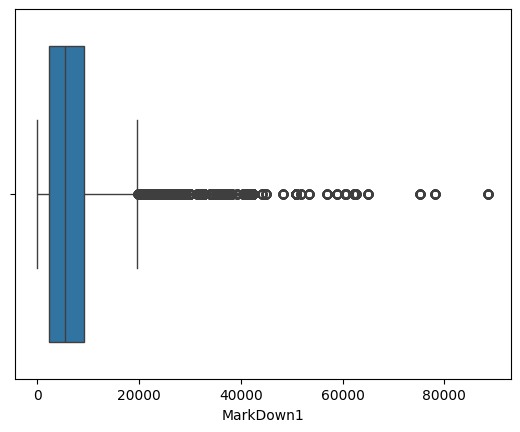

In [13]:
sns.boxplot(x = 'MarkDown1', data = df_train)
plt.show()

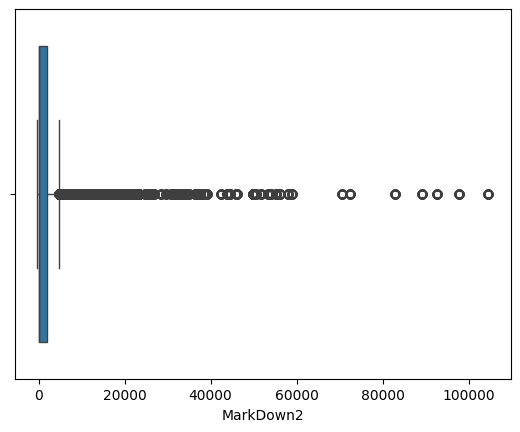

In [14]:
sns.boxplot(x = 'MarkDown2', data = df_train)
plt.show()

So this might look like "outliers" but since this is a retail sales data, it might be spikes or drops but not true errors due to promotions, events, seasonality and holidays.

In [15]:
df_train['Type'].value_counts()

Type
A    215478
B    163495
C     42597
Name: count, dtype: int64

We'll need to encode this column, so we're gonna use OneHotEncoder

In [16]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [17]:
encoded_train = encoder.fit_transform(df_train[["Type"]])
encoded_test = encoder.fit_transform(df_test[["Type"]])

In [18]:
encoded_df_train = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(["Type"]))
encoded_df_test = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(["Type"]))

In [19]:
df_train = df_train.drop("Type", axis=1).join(encoded_df_train)
df_test  = df_test.drop("Type", axis=1).join(encoded_df_test)

In [20]:
df_test.head()

,Store,Dept,Date,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C
0,1,1,2012-11-02,False,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,0.0,0.0
1,1,1,2012-11-09,False,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,0.0,0.0
2,1,1,2012-11-16,False,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,0.0,0.0
3,1,1,2012-11-23,True,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,0.0,0.0
4,1,1,2012-11-30,False,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,0.0,0.0


In [21]:
df_test.isna().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type_B              0
Type_C              0
dtype: int64

In [22]:
df_train = fill_nulls(df_train, 'MarkDown1')
df_train = fill_nulls(df_train, 'MarkDown2')
df_train = fill_nulls(df_train, 'MarkDown3')
df_train = fill_nulls(df_train, 'MarkDown4')
df_train = fill_nulls(df_train, 'MarkDown5')

In [23]:
df_test = fill_nulls(df_test, 'MarkDown1')
df_test = fill_nulls(df_test, 'MarkDown2')
df_test = fill_nulls(df_test, 'MarkDown3')
df_test = fill_nulls(df_test, 'MarkDown4')
df_test = fill_nulls(df_test, 'CPI')
df_test = fill_nulls(df_test, 'Unemployment')

In [24]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0.0,0.0
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0.0,0.0
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0.0,0.0
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0.0,0.0
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0.0,0.0


In [25]:
df_test.head()

,Store,Dept,Date,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C
0,1,1,2012-11-02,False,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,0.0,0.0
1,1,1,2012-11-09,False,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,0.0,0.0
2,1,1,2012-11-16,False,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,0.0,0.0
3,1,1,2012-11-23,True,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,0.0,0.0
4,1,1,2012-11-30,False,151315,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,0.0,0.0


We're gonna merge both data frames to create correct lags then split them again

In [26]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

In [27]:
split_date = df_train["Date"].max()

In [28]:
full_df = pd.concat([df_train, df_test], axis=0)

Creating the time-based features

In [29]:
full_df["Day"] = full_df["Date"].dt.day
full_df["Month"] = full_df["Date"].dt.month
full_df["Year"] = full_df["Date"].dt.year
full_df["DayOfWeek"] = full_df["Date"].dt.dayofweek
full_df["IsWeekend"] = full_df["DayOfWeek"].isin([5,6]).astype(int)

In [30]:
full_df["Lag_1"] = full_df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
full_df["Lag_4"] = full_df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)

In [31]:
full_df["Rolling_Mean_4"] = full_df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(4).mean())
full_df["Rolling_Mean_12"] = full_df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(12).mean())

Splitting the datasets using the date we got form earlier

In [32]:
df_train = full_df.loc[full_df["Date"] <= split_date].copy()
df_test  = full_df.loc[full_df["Date"] >  split_date].copy()

In [33]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Type_C,Day,Month,Year,DayOfWeek,IsWeekend,Lag_1,Lag_4,Rolling_Mean_4,Rolling_Mean_12
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,0.0,0.0,...,0.0,5,2,2010,4,0,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,0.0,0.0,...,0.0,12,2,2010,4,0,24924.50,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,0.0,0.0,...,0.0,19,2,2010,4,0,46039.49,NaN,NaN,NaN
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,0.0,0.0,...,0.0,26,2,2010,4,0,41595.55,NaN,32990.77,NaN
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,0.0,0.0,...,0.0,5,3,2010,4,0,19403.54,24924.5,32216.62,NaN


In [34]:
df_test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Type_C,Day,Month,Year,DayOfWeek,IsWeekend,Lag_1,Lag_4,Rolling_Mean_4,Rolling_Mean_12
0,1,1,2012-11-02,NaN,False,151315,55.32,3.386,6766.44,5147.70,...,0.0,2,11,2012,4,0,27390.81,21904.47,NaN,NaN
1,1,1,2012-11-09,NaN,False,151315,61.24,3.314,11421.32,3370.89,...,0.0,9,11,2012,4,0,NaN,22764.01,NaN,NaN
2,1,1,2012-11-16,NaN,False,151315,52.92,3.252,9696.28,292.10,...,0.0,16,11,2012,4,0,NaN,24185.27,NaN,NaN
3,1,1,2012-11-23,NaN,True,151315,56.23,3.211,883.59,4.17,...,0.0,23,11,2012,4,0,NaN,27390.81,NaN,NaN
4,1,1,2012-11-30,NaN,False,151315,52.34,3.207,2460.03,0.00,...,0.0,30,11,2012,4,0,NaN,NaN,NaN,NaN


So after adding the time based features and splitting the data sets again we fill the nans created by the lags, we won't drop them cause that may affect the training and testing

In [35]:
df_train = df_train.dropna()
df_test  = df_test.fillna(0)

## Building & Training Models

In [ ]:
x_train = df_train.drop("Weekly_Sales", axis=1)
y_train = df_train["Weekly_Sales"]

x_test = df_test.drop("Weekly_Sales", axis=1)
y_test = df_test["Weekly_Sales"]

In [42]:
lr_model = build_train_model('linear_regression', x_train, y_train)
xgb_model = build_train_model('xgboost', x_train, y_train)

linear_regression model trained successfully.
xgboost model trained successfully.


In [43]:
y_pred_lr = lr_model.predict(x_test)

y_pred_xgb = xgb_model.predict(x_test)

In [48]:
y_test = y_test.reset_index(drop=True)

y_pred_lr = pd.Series(y_pred_lr, index=y_test.index)

y_pred_xgb = pd.Series(y_pred_xgb, index=y_test.index)

dates = df_test.loc[y_test.index, "Date"].reset_index(drop=True)

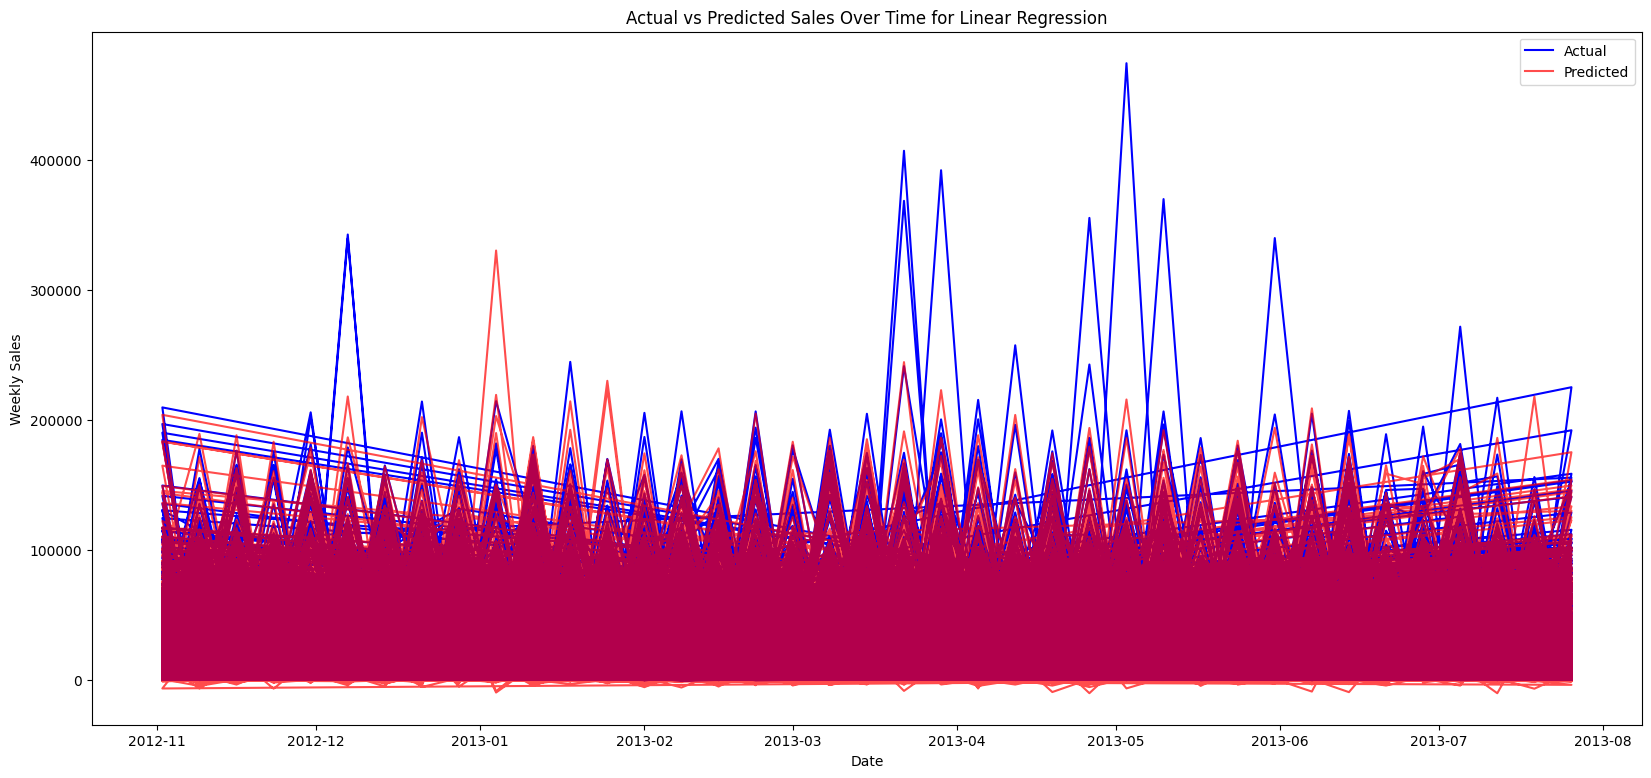

In [53]:
plt.figure(figsize=(20,9))
plt.plot(dates, y_test, label="Actual", color="blue")
plt.plot(dates, y_pred_lr, label="Predicted", color="red", alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Actual vs Predicted Sales Over Time for Linear Regression")
plt.legend()
plt.show()

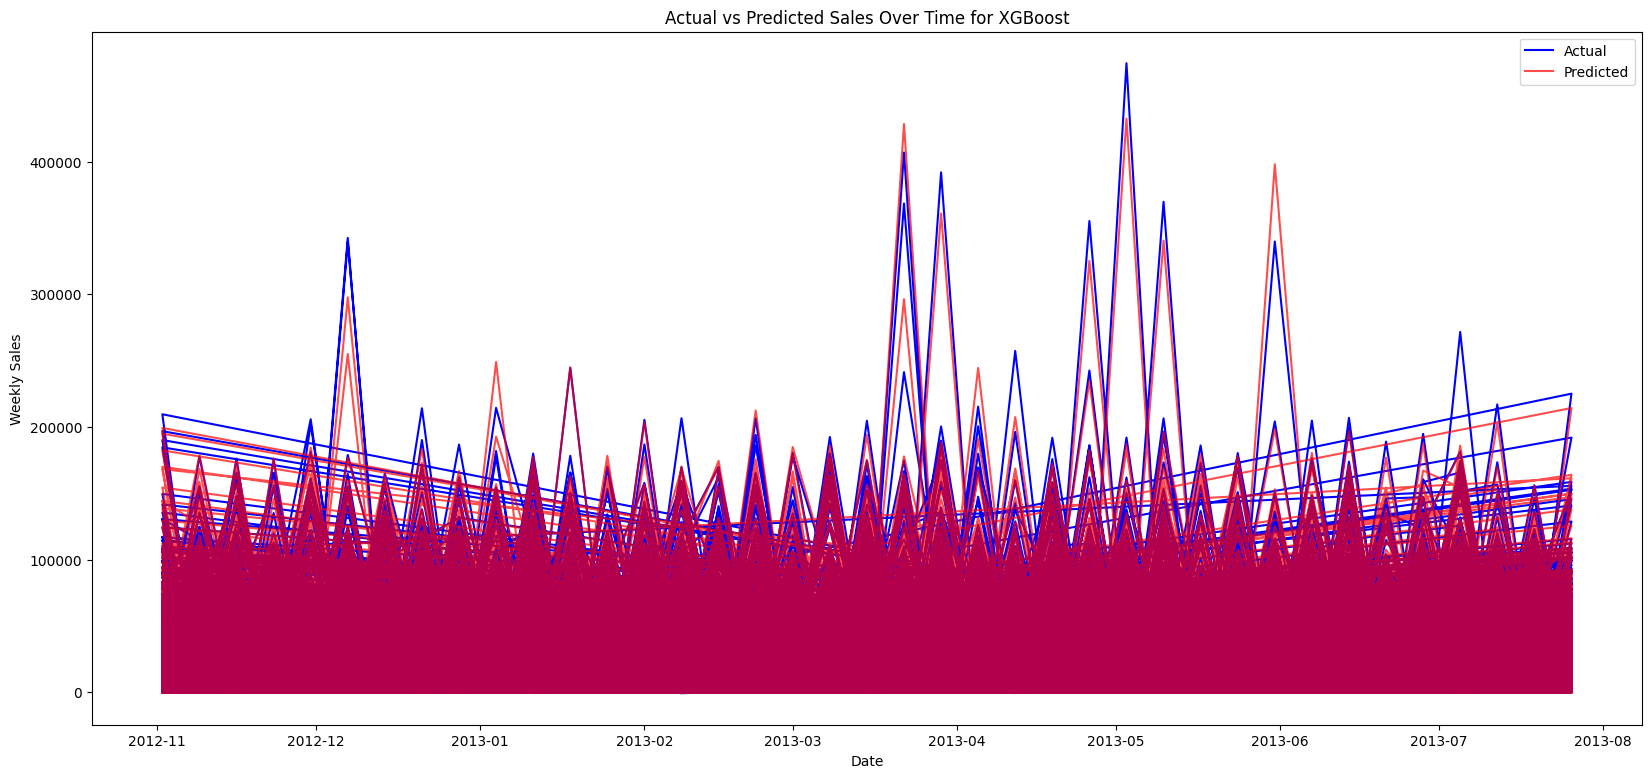

In [54]:
plt.figure(figsize=(20,9))
plt.plot(dates, y_test, label="Actual", color="blue")
plt.plot(dates, y_pred_xgb, label="Predicted", color="red", alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Actual vs Predicted Sales Over Time for XGBoost")
plt.legend()
plt.show()

From the graphs we can see that the xgb model is doing way better at predicitng the large spikes than the liner regression model